In [1]:
using CollectiveSpins
using PyPlot
using JLD2
using QuantumOptics
using Statistics

In [2]:
""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array)
    phi_array = zeros(N)
    for i = 1:N
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end


""" Return H_ZZ for the spin collection S """
function compute_H_ZZ(Nx, Ny, Nz, bMB, Ω_ZZ_coeff)
    H = SparseOperator(bMB)
    Matidx = reshape([1:N;], Nx, Ny, Nz)
    
    for i=1:N
        idx = findall(x->x==i, Matidx)[1]
        x, y, z = idx[1], idx[2], idx[3]

        # Neighbourg displacment
        neighbors = [
        (1, 0, 0), (-1, 0, 0),
        (0, 1, 0), (0, -1, 0),
        (0, 0, 1), (0, 0, -1)
        ]

        for (dx, dy, dz) in neighbors
            xj, yj, zj = x + dx, y + dy, z + dz
            # Check if neighbours are on the lattice
            if 1 <= xj <= Nx && 1 <= yj <= Ny && 1 <= zj <= Nz
                j = LinearIndices((Nx, Ny, Nz))[xj, yj, zj]
                
                H += (Ω_ZZ_coeff[1] * embed(bMB, i, σp*σm)*embed(bMB, j, σp*σm) + 
                    Ω_ZZ_coeff[2] * (embed(bMB, i, σp*σm)*embed(bMB, j, σm*σp) + embed(bMB, i, σm*σp)*embed(bMB, j, σp*σm)) + 
                    Ω_ZZ_coeff[3] * embed(bMB, i, σm*σp)*embed(bMB, j, σm*σp))
            end
        end
    end
    return H
end

""" Compute the spin flip exchange hamiltonian """
function compute_H_SFE(N, bMB, Ω_CSC)
    H = SparseOperator(bMB)
    
    for i=1:N, j=1:N
        if i==j
            continue
        end
        
        H += Ω_CSC[i, j] * embed(bMB, i, σp)*embed(bMB, j, σm)
        
    end
    return H
end

compute_H_SFE

### Define the system

In [3]:
# Define geometry of system
Nx,Ny,Nz = [1,2,4]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532. # Optical lattice spacing in nm
e = [0,0,1]   # Quantization axis
Γ0 = 1. # In Hz

theta_init = pi/2
phi_init = 1

θl = 30*pi/180 # Angle of the laser
λ = 1299.

a,b,c = [d_xy,d_xy,d_z]/λ
geo = geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
system = SpinCollection(geo, e, gammas=1.)

Ω_ZZ_coeff = [53, 42, 33]./Γ0

Tstep, Tend = 1e-3, 1 # Normalised by Γ0
T = [0:Tstep:Tend;];

# Full Quantum

In [4]:
# Basis
b1 = SpinBasis(1//2)
bMB = CompositeBasis([b1 for i = 1:N])

# Single atom operators
σx = sigmax(b1)
σy = sigmay(b1)
σz = sigmaz(b1)
σp = sigmap(b1)
σm = sigmam(b1)

# Single atoms σz for a -6/-7 system
σz67 = -7*(σp*σm) -6*(σm*σp)

# Many body operators
Jx = sum([embed(bMB, i, σx) for i = 1:N])
Jy = sum([embed(bMB, i, σy) for i = 1:N])
Jz67 = sum([embed(bMB, i, σz67) for i = 1:N]);

In [5]:
Ω_CS = CollectiveSpins.OmegaMatrix(system)
Γ_CS = CollectiveSpins.GammaMatrix(system)

# Hamiltonian
HCS = compute_H_SFE(N, bMB, Ω_CS)
HZZ = compute_H_ZZ(Nx, Ny, Nz, bMB, Ω_ZZ_coeff)
H = HCS + HZZ

# Construct Jump operators
J = [embed(bMB, i, σm) for i = 1:N];

In [6]:
theta_array = ones(N)*theta_init
phi_array = prepare_phi_IS(θl, λ, theta_array)*phi_init
Ψ0_Q = CollectiveSpins.quantum.blochstate(phi_array, theta_array)
ρt_Q = timeevolution.master(T, Ψ0_Q, H, J, rates=Γ_CS, dt=Tstep)[2];

In [7]:
mean_σx = [real(expect(Jx, ρ))./N for ρ in ρt_Q]
mean_σy = [real(expect(Jy, ρ))./N for ρ in ρt_Q]
mean_σz67 = [real(expect(Jz67, ρ))./N for ρ in ρt_Q];

### QC C functions

In [8]:
@load "Sol_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)" sol;

In [ ]:
mean_σx_QC = [2*mean(real(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σy_QC = [2*mean(imag(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σz_QC = [2*mean(real(sol[i][1:N]))-1 for i=1:length(T)]
mean_σz67_QC = -1 .*(mean_σz_QC.+1) ./2 .- 6;

# Plots

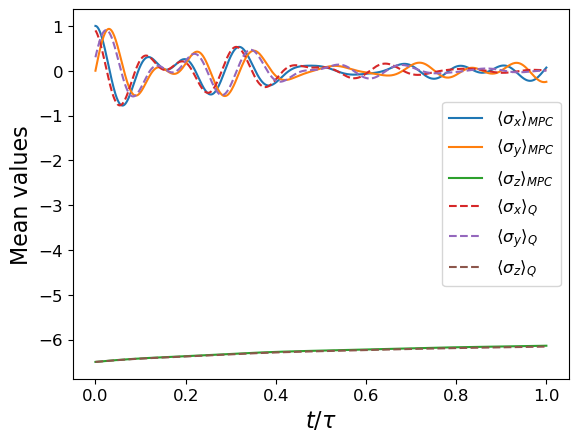

In [10]:
close("all")
figure()

PyPlot.rc("font", size = 12)

plot(T, mean_σx_QC, label=L"$\langle\sigma_x\rangle_{MPC}$")
plot(T, mean_σy_QC, label=L"$\langle\sigma_y\rangle_{MPC}$")
plot(T, mean_σz67_QC, label=L"$\langle\sigma_z\rangle_{MPC}$")

plot(T, mean_σx, label=L"$\langle\sigma_x\rangle_{Q}$", linestyle="--")
plot(T, mean_σy, label=L"$\langle\sigma_y\rangle_{Q}$", linestyle="--")
plot(T, mean_σz67, label=L"$\langle\sigma_z\rangle_{Q}$", linestyle="--")

xlabel(L"t/\tau", fontsize=16)
ylabel("Mean values", fontsize=16)

legend()
pygui(false); gcf()

In [11]:
savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Comparison_QC_Q_ElecMgtDD_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_phi_$(phi_init)_theta_$(round(theta_init, digits=1)).pdf", bbox_inches="tight")

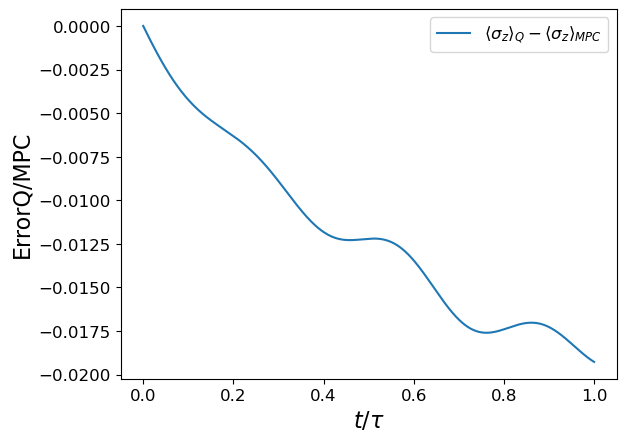

In [12]:
close("all")
figure()

PyPlot.rc("font", size = 12)

plot(T, mean_σz67-mean_σz67_QC, label=L"\langle\sigma_z\rangle_{Q}-\langle\sigma_z\rangle_{MPC}")

xlabel(L"t/\tau", fontsize=16)
ylabel("ErrorQ/MPC", fontsize=16)

legend()
pygui(false); gcf()

In [13]:
savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Error_QC_Q_ElecMgtDD_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_phi_$(phi_init)_theta_$(round(theta_init, digits=1))_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")

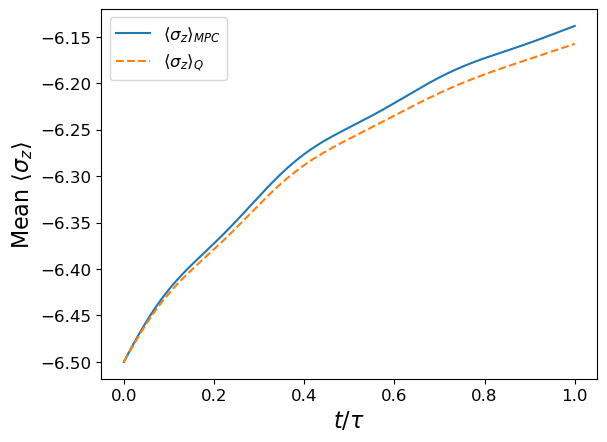

In [14]:
close("all")
figure()

PyPlot.rc("font", size = 12)

plot(T, mean_σz67_QC, label=L"\langle\sigma_z\rangle_{MPC}")
plot(T, mean_σz67, label=L"\langle\sigma_z\rangle_{Q}", linestyle="--")


xlabel(L"t/\tau", fontsize=16)
ylabel(L"Mean $\langle\sigma_z\rangle$", fontsize=16)

legend()
pygui(false); gcf()

In [15]:
savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Sigmaz_QC_Q_ElecMgtDD_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_phi_$(phi_init)_theta_$(round(theta_init, digits=1))_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")

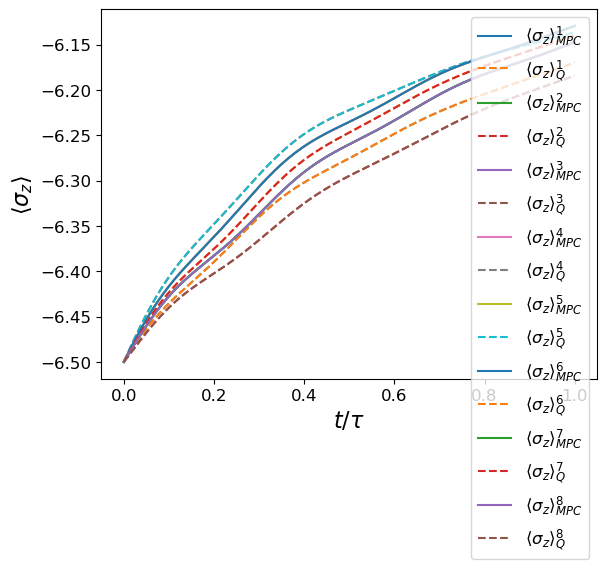

In [16]:
close("all")
figure()

PyPlot.rc("font", size = 12)

for n = 1:N
    plot(T, [-1*real(sol[i][n]) - 6 for i=1:length(T)], label=label = "\$\\langle\\sigma_z\\rangle_{MPC}^{$(string(n))}\$")
    plot(T, [real(expect(embed(bMB, n, σz67), ρ)) for ρ in ρt_Q], label=label = "\$\\langle\\sigma_z\\rangle_{Q}^{$(string(n))}\$", linestyle="--")
end

xlabel(L"t/\tau", fontsize=16)
ylabel(L"\langle\sigma_z\rangle", fontsize=16)

legend()
pygui(false); gcf()

In [17]:
savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Sigmazi_QC_Q_ElecMgtDD_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_phi_$(phi_init)_theta_$(round(theta_init, digits=1))_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")